In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from '/home/hpc/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PowerLawNuisanceSpectralModel,
    PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
from Dataset_Creation import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : TH6JXws7 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

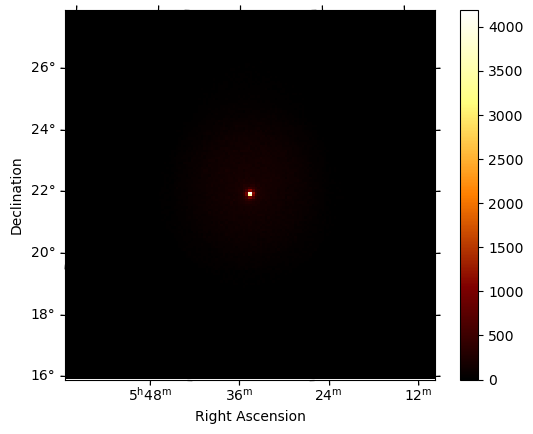

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models([source_model])

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy(name="Source"))
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Asimov Cases

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value


shift_neg = +0.1
shift_pos = -0.1
shift_cor = 0.0

delta_shift = 0.08
n = len(true_energy)
tilt_neg = -delta_shift/n 
tilt_pos = delta_shift/n 
tilt_cor = 0


tilt_neg = 0 
tilt_pos = 0 
print(tilt_neg)

0


In [5]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_cor, 
                        tilt = tilt_cor,
                        rnd = False)
dataset_cor_N = sys_d_cor.create_dataset_N()

sys_d_neg = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_neg, 
                        tilt = tilt_neg,
                        rnd = False)
dataset_neg_N = sys_d_neg.create_dataset_N()

sys_d_pos = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_pos, 
                        tilt = tilt_pos,
                        rnd = False)
dataset_pos_N = sys_d_pos.create_dataset_N()
sigma_a = .1
sigma_i = tilt_pos
sigma_i = 1e-12
zero = 1e-24

#penalising_covmatrix = [[1/sigma_i**2, zero], [zero , 1/sigma_a**2]]
penalising_covmatrix = [[1/sigma_a**2]]

penalising_invcovmatrix =  penalising_covmatrix

dataset_pos_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_neg_N.penalising_invcovmatrix = penalising_invcovmatrix

datasets  = [dataset_pos_N, dataset_cor_N, dataset_neg_N]

{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0


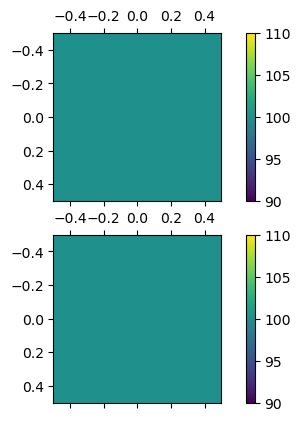

In [6]:
fig, ax = plt.subplots(2,1)
#ax = fig.add_subplot(111)
cax = ax[0].matshow(penalising_covmatrix)  # interpolation='nearest')
fig.colorbar(cax);
cax = ax[1].matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);

corr
{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.72387229>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 1.87612771>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.34238723>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.25761277>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.31863267>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area

par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
par 1
mat [[99.99999999999999]]
par 1
mat [[99.99999999999999]]
par 1
mat [[99.99999999999999]]
par 1
mat [[99.999999999999

par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.31549181>, 'amplitude': <Quantity 9.50612189e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.31549181>, 'amplitude': <Quantity 8.99997758e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.31549181>, 'amplitude': <Quantity 9.25304973e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.04238723>}
0.04238722809628949
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.31549181>, 'amplitude': <Quantity 9.25304973e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity -0.04238723>}
-0.04238722809628949
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.31549181>, 'amplitude': <Quantity 9.25304973e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]

{'index': <Quantity 2.30099299>, 'amplitude': <Quantity 9.10239501e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30099299>, 'amplitude': <Quantity 9.10239501e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30099299>, 'amplitude': <Quantity 9.10239501e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
par 1
mat [[99.99999999999999]]
par 1
mat [[99.99999999999999]]
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30059149>, 'amplitude': <Quantity 9.10070253e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.3008464>, 'amplitude': <Quantity 9.10177707e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99

par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30089972>, 'amplitude': <Quantity 9.10197959e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.04238723>}
0.04238723063746124
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30089972>, 'amplitude': <Quantity 9.10197959e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity -0.04238723>}
-0.04238723063746124
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30089972>, 'amplitude': <Quantity 9.10197959e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30089972>, 'amplitude': <Quantity 9.10197959e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30089972>, 'amplitude': <Quantity 9.10197959e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]

{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
par 1
mat [[99.99999999999999]]
par 1
mat [[99.99999999999999]]
par 1
mat [[99.99999999999999]]
par 1
mat [[99.99999999999999]]
par 1
mat [[99.999999999999

par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30256416>, 'amplitude': <Quantity 1.11572222e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30256416>, 'amplitude': <Quantity 1.11572222e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
par 1
mat [[99.99999999999999]]
par 1
mat [[99.99999999999999]]
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30057401>, 'amplitude': <Quantity 1.11232069e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30182537>, 'amplitude': <Quantity 1.1144595e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.3022248>, 'amplitude': <Quantity 1.11514218e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quan

par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.29843295>, 'amplitude': <Quantity 1.11504448e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30291764>, 'amplitude': <Quantity 1.11504448e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30142274>, 'amplitude': <Quantity 1.11504448e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30217019>, 'amplitude': <Quantity 1.12107888e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30217019>, 'amplitude': <Quantity 1.10901009e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30217019>, 'amplitude': <Q

{'index': <Quantity 2.28349107>, 'amplitude': <Quantity 1.11504448e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30217019>, 'amplitude': <Quantity 1.1574254e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30217019>, 'amplitude': <Quantity 1.07266357e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30217019>, 'amplitude': <Quantity 1.14520867e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30217019>, 'amplitude': <Quantity 1.0848803e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30217019>, 'amplitude': <Quantity 1.11504448e-12 1 / (cm2 s 

par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30216258>, 'amplitude': <Quantity 1.11503171e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity -1.00740182e-14>}
-1.0074018152145958e-14
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30216674>, 'amplitude': <Quantity 1.11503869e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity -4.56715059e-15>}
-4.567150590908136e-15
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30216863>, 'amplitude': <Quantity 1.11504185e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity -2.07384824e-15>}
-2.0738482369419143e-15
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30216949>, 'amplitude': <Quantity 1.1150433e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity -9.359293e-16>}
-9.359292997728348e-16
par 1
mat [[99.99999999999999]]
{'index': <Quantity 2.30216988>, 'amplitude': <Quantity 1.11504395e-12 1 / (cm2 s TeV)>, 'reference': <Qu

<AxesSubplot: >

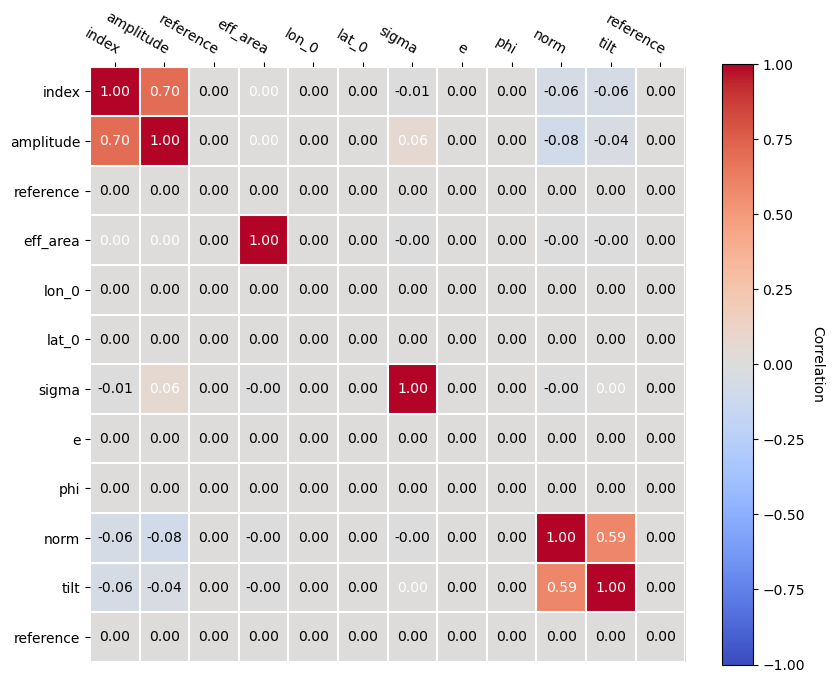

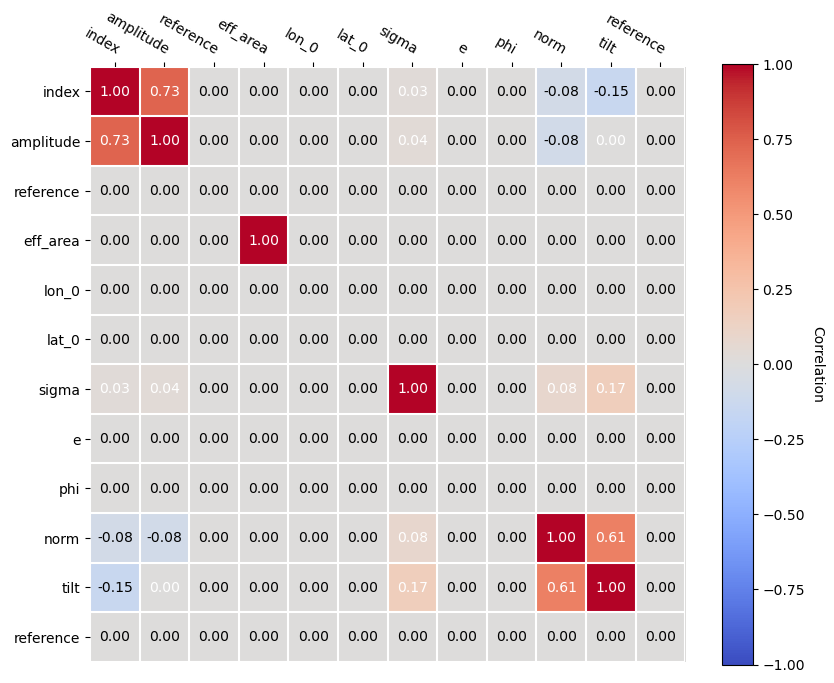

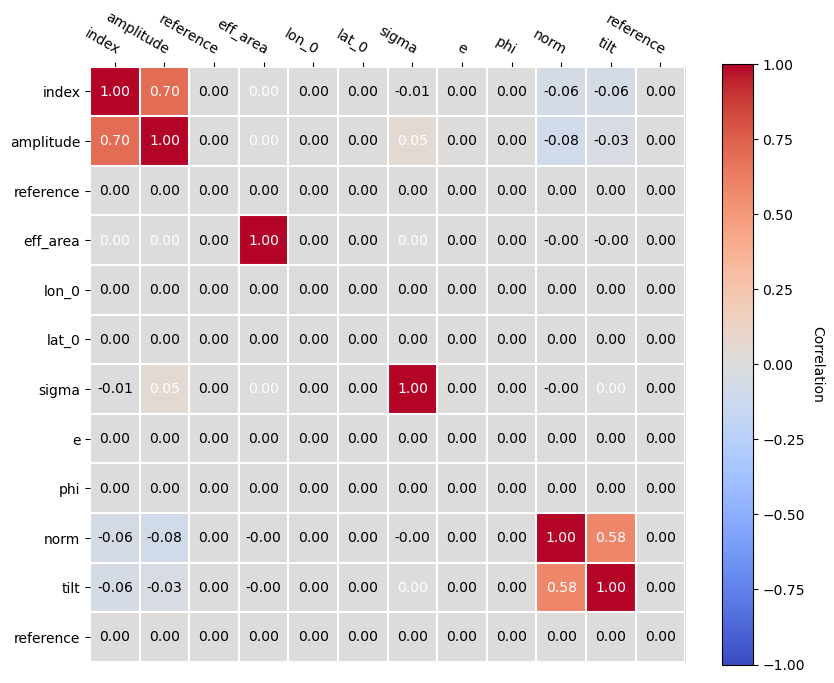

In [7]:
%%time
print("corr")
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run(dataset_cor_N)
        
print("neg")
fit_neg = Fit(store_trace=False)
result_neg = fit_neg.run(dataset_neg_N)

print("pos")
fit_pos = Fit(store_trace=False)
result_pos = fit_pos.run(dataset_pos_N)


dataset_pos_N.models.covariance = fit_pos.covariance(dataset_pos_N).matrix
dataset_pos_N.models.covariance.plot_correlation()

dataset_neg_N.models.covariance = fit_neg.covariance(dataset_neg_N).matrix
dataset_neg_N.models.covariance.plot_correlation()

dataset_cor_N.models.covariance = fit_cor.covariance(dataset_cor_N).matrix
dataset_cor_N.models.covariance.plot_correlation()



In [8]:
datasets = Datasets([dataset_cor_N])
datasets.parameters.unique_parameters.names

['index',
 'amplitude',
 'reference',
 'eff_area',
 'lon_0',
 'lat_0',
 'sigma',
 'e',
 'phi',
 'norm',
 'tilt',
 'reference']

In [9]:
result_cor.models[0].spectral_model(1*u.TeV)

{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0


<Quantity 1.e-12 1 / (cm2 s TeV)>

In [10]:
result_cor.models.parameters.names

['index',
 'amplitude',
 'reference',
 'eff_area',
 'lon_0',
 'lat_0',
 'sigma',
 'e',
 'phi',
 'norm',
 'tilt',
 'reference']

In [11]:
dataset_neg_N.models[0].spectral_model.parameters.names

['index', 'amplitude', 'reference', 'eff_area']

In [12]:
'''from gammapy.modeling.fit import Registry

def set_cov(dataset, fit , result):

    kwargs = fit.covariance_opts.copy()
    kwargs["minuit"] = fit.minuit
    backend = kwargs.pop("backend", fit.backend)
    registry  = Registry()
    compute = registry.get("covariance", backend)
    datasets, unique_pars = fit._parse_datasets(datasets=[dataset])
    
    parameters = datasets.models.parameters

    print((parameters.names))
    with parameters.restore_status():
        print((parameters.names))

        factor_matrix, info = compute(
            parameters=parameters, function=datasets.stat_sum, **kwargs
        )
        print(np.shape(factor_matrix))
        matrix = Covariance.from_factor_matrix(
            parameters=parameters, matrix=factor_matrix
        )
        #datasets.models.covariance = matrix
    return matrix'''

'from gammapy.modeling.fit import Registry\n\ndef set_cov(dataset, fit , result):\n\n    kwargs = fit.covariance_opts.copy()\n    kwargs["minuit"] = fit.minuit\n    backend = kwargs.pop("backend", fit.backend)\n    registry  = Registry()\n    compute = registry.get("covariance", backend)\n    datasets, unique_pars = fit._parse_datasets(datasets=[dataset])\n    \n    parameters = datasets.models.parameters\n\n    print((parameters.names))\n    with parameters.restore_status():\n        print((parameters.names))\n\n        factor_matrix, info = compute(\n            parameters=parameters, function=datasets.stat_sum, **kwargs\n        )\n        print(np.shape(factor_matrix))\n        matrix = Covariance.from_factor_matrix(\n            parameters=parameters, matrix=factor_matrix\n        )\n        #datasets.models.covariance = matrix\n    return matrix'

In [13]:
#cov = set_cov(dataset_pos_N,fit_pos, result_pos )

In [14]:
datasets_short = [dataset_neg_N, dataset_cor_N, dataset_pos_N]

for d in datasets_short:
    for p in d.models.parameters.penalised_parameters:
        p.frozen = True


print("best fit amplitude")
amplitudes_N = []
m = dataset_asimov.models[0]
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models[0]
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes_N.append((value, error))
    print(f'{value} pm {error}')
print()
print("best fit Index")
indices_N = []
m = dataset_asimov.models[0]
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models[0]
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices_N.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms_N = []
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms_N.append((value, error))
    

best fit amplitude
====
Input
1e-12 pm 0.0
====
9.101965611455044e-13 pm 8.350765210384867e-14
1e-12 pm 8.982377778353684e-14
1.1150444825910317e-12 pm 9.998510343142408e-14

best fit Index
====
Input
2.3 pm 0.0
====
2.3008969026728976 pm 0.06273508984906531
2.3 pm 0.06171637176835362
2.302170193837867 pm 0.06175505369080584

Best Fit bkg Norm
====
Input
1.0 pm 0
====
0.999963736277165 pm 0.0020441098797690832
1.0 pm 0.00206238916408096
0.9999907337519418 pm 0.0020658838448179085


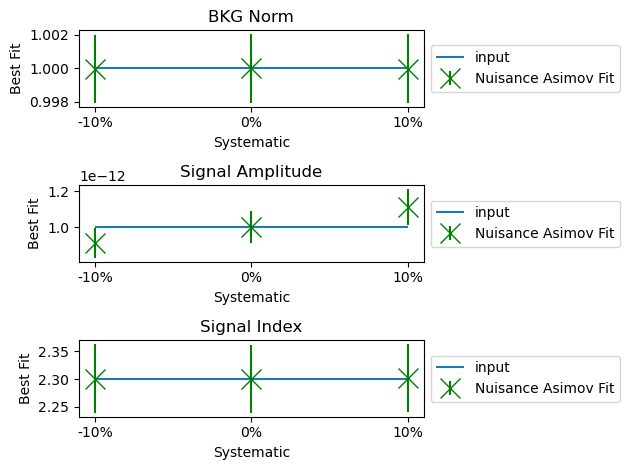

In [15]:
fig, axs = plt.subplots(3,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']
label = "Nuisance Asimov Fit"

for i, a in enumerate(norms_N[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[0].hlines( norms_N[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes_N[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[1].hlines( amplitudes_N[0][0], 1, 3, label = "input")

for i, a in enumerate(indices_N[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( indices_N[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1, 0.5))
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels_sys)

plt.tight_layout()    
#fig.savefig("best_fit_parameters_corr.pdf")   


{'index': <Quantity 2.3008969>, 'amplitude': <Quantity 9.10196561e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
index
{'index': <Quantity 2.30090318>, 'amplitude': <Quantity 9.10196561e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
amplitude
{'index': <Quantity 2.3008969>, 'amplitude': <Quantity 9.10204912e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
{'index': <Quantity 2.3008969>, 'amplitude': <Quantity 9.10196561e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
index
{'index': <Quantity 2.30090318>, 'amplitude': <Quantity 9.10196561e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
amplitude
{'index': <Quantity 2.3008969>, 'amplitude': <Quantity 9.10204912e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
{'index': <Quantity 2.3>, 'amplitude': <Quantity 1.e-12 1 / 

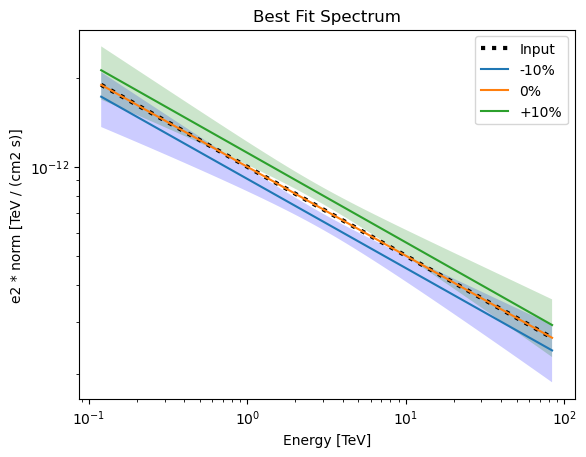

In [16]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')

dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "-10%")
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='blue')

dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "0%")
                                   
#dataset_cor_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                       facecolor='orange')


                               
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "+10%")
dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                        facecolor = 'green')


plt.legend()

plt.title("Best Fit Spectrum")
fig = plt.gcf()
#fig.savefig("plots/2_spectrum.pdf")

In [17]:
'''true_energy = dataset_cor_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')

dataset_neg_N.models[0].spectral_model.model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "-10%")
dataset_neg_N.models[0].spectral_model.model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='blue')

dataset_cor_N.models[0].spectral_model.model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "0%")
                                   
#dataset_cor_N.models['Source'].spectral_model.model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                       facecolor='orange')


                               
dataset_pos_N.models[0].spectral_model.model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "+10%")
dataset_pos_N.models[0].spectral_model.model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                        facecolor = 'green')


plt.legend()

plt.title("Best Fit Spectrum")
fig = plt.gcf()
#fig.savefig("plots/2_spectrum.pdf")'''

'true_energy = dataset_cor_N.exposure.geom.axes[0].center.value\n\n\nfig,ax = plt.subplots()\nenergy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV\ndataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, \n                                label = "Input", color = \'black\', linewidth = 3, linestyle =\'dotted\')\n\ndataset_neg_N.models[0].spectral_model.model.plot(energy_bounds,  energy_power = 2, ax = ax,\n                                label = "-10%")\ndataset_neg_N.models[0].spectral_model.model.plot_error(energy_bounds,  energy_power = 2, ax = ax,\n                                                       facecolor=\'blue\')\n\ndataset_cor_N.models[0].spectral_model.model.plot(energy_bounds,  energy_power = 2, ax = ax,\n                                label = "0%")\n                                   \n#dataset_cor_N.models[\'Source\'].spectral_model.model.plot_error(energy_bounds,  energy_power = 2, ax = ax,\n#                                       

0.0 0.09999999999540742
0.0 0.10000000000984115
0.0 0.10000000001059509


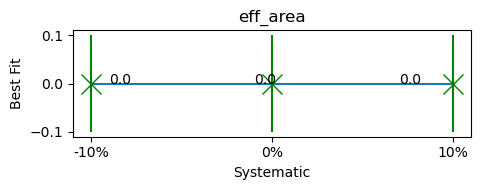

In [18]:
n_nui = len(dataset_neg_N.models.parameters.penalised_parameters)
fig, a  = plt.subplots(n_nui, 1, figsize = (5,2* n_nui))
if n_nui ==1:
    a = [a]
label = 'Nuisance Fit'
iss = [1.1, 1.9, 2.7]
for j, par_name in enumerate(dataset_neg_N.models.parameters.penalised_parameters.names):
    for i, d in enumerate([dataset_neg_N, dataset_cor_N, dataset_pos_N]):
        value = d.models.parameters[par_name].value
        error = d.models.parameters[par_name].error
        print(value, error)

        a[j].errorbar(x= i+1, y = value, yerr = error, fmt= 'x', color =  'green',markersize=14,
                       label = label)
        a[j].text(iss[i],-value, f'{value:.2}', )
    a[j].hlines( 0., 1, 3, label = "input")

    a[j].set_ylabel('Best Fit' ); 
    a[j].set_title(par_name)
    a[j].set_xlabel('Systematic'); 
    a[j].set_xticks(np.arange(3)+1,labels_sys);

plt.tight_layout()
#fig.savefig("plots/2_best_fit_nui.pdf")

## Comparison

In [19]:
path = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Eff_area/energy_independent/'
with open(path + 'data/1_norms.yaml') as file:
    norms = yaml.load( file, Loader=yaml.FullLoader)
with open(path + 'data/1_amplitudes.yaml') as file:
    amplitudes = yaml.load( file, Loader=yaml.FullLoader)
with open(path + 'data/1_indices.yaml') as file:
    indices = yaml.load( file, Loader=yaml.FullLoader)
    


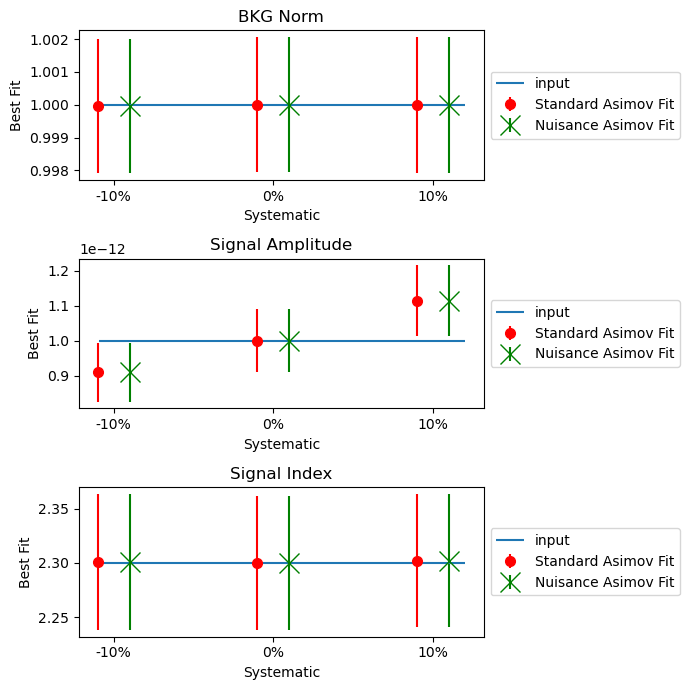

In [20]:
fig, axs = plt.subplots(3,1, figsize= (7, 7))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    label = "Standard Asimov Fit"
    axs[0].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
    
for i, a in enumerate(norms_N[1:]):
    label = "Nuisance Asimov Fit"
    axs[0].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(amplitudes_N[1:]):
    axs[1].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(indices_N[1:]):
    axs[2].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( indices[0][0], 0.91, 3.2, label = "input")
axs[0].hlines( norms[0][0], 0.91, 3.2, label = "input")
axs[1].hlines( amplitudes[0][0], 0.91, 3.2, label = "input")

plt.tight_layout()
for ax in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(3)+1,labels_sys)

    
#axs[0].set_ylim(0.85, 1.15)
plt.tight_layout()    
#fig.savefig("plots/2_best_fit_parameters_comparison.pdf")   


### Spectrum

In [21]:
dataset_st_neg = dataset_neg_N.copy()
dataset_st_neg.models = Models.read(path+"data/1_model_neg.yml")

dataset_st_pos = dataset_pos_N.copy()
dataset_st_pos.models = Models.read(path+"data/1_model_pos.yml")

dataset_st_cor = dataset_cor_N.copy()
dataset_st_cor.models = Models.read(path+"data/1_model_cor.yml")

In [22]:
for d in datasets:
    for p in d.models.parameters.penalised_parameters:
        p.frozen = True

In [23]:
#dataset_neg_N.models[0].spectral_model.parameters['eff_area'].frozen = True
#dataset_pos_N.models[0].spectral_model.parameters['eff_area'].frozen = True
#dataset_cor_N.models[0].spectral_model.parameters['eff_area'].frozen = True

In [24]:
print(dataset_neg_N.models[0].spectral_model)

NuisanceNorm

  type      name     value         unit        error   min max frozen is_norm is_penalised link
-------- --------- ---------- -------------- --------- --- --- ------ ------- ------------ ----
spectral     index 2.3009e+00                6.274e-02 nan nan  False   False        False     
spectral amplitude 9.1020e-13 cm-2 s-1 TeV-1 8.351e-14 nan nan  False    True        False     
spectral reference 1.0000e+00            TeV 0.000e+00 nan nan   True   False        False     
spectral  eff_area 0.0000e+00                1.000e-01 nan nan   True   False         True     


In [25]:
#print(dataset_neg_N.models[0].spectral_model.model)

In [26]:
dataset_neg_N.models[0].spectral_model.covariance.data

array([[3.93569150e-03, 3.83650975e-15, 0.00000000e+00, 0.00000000e+00],
       [3.83650975e-15, 6.97352796e-27, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e-02]])

In [27]:
#dataset_neg_N.models[0].spectral_model.model.covariance.data

In [28]:
dataset_st_neg.models[0].spectral_model.covariance.data

array([[3.93893047e-03, 3.85181596e-15, 0.00000000e+00],
       [3.85181596e-15, 6.98798249e-27, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [29]:
print(dataset_st_neg.models)

DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.301   +/-    0.06             
    amplitude                     :   9.10e-13   +/- 8.4e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.020   +/-    0.01 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         




{'index': <Quantity 2.3008969>, 'amplitude': <Quantity 9.10196561e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
index
{'index': <Quantity 2.30090318>, 'amplitude': <Quantity 9.10196561e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
amplitude
{'index': <Quantity 2.3008969>, 'amplitude': <Quantity 9.10204912e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
{'index': <Quantity 2.3008969>, 'amplitude': <Quantity 9.10196561e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
index
{'index': <Quantity 2.30090318>, 'amplitude': <Quantity 9.10196561e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
amplitude
{'index': <Quantity 2.3008969>, 'amplitude': <Quantity 9.10204912e-13 1 / (cm2 s TeV)>, 'reference': <Quantity 1. TeV>, 'eff_area': <Quantity 0.>}
0.0
index
amplitude
index
amplitude
{'index': <Quantity 2.3>, 'a

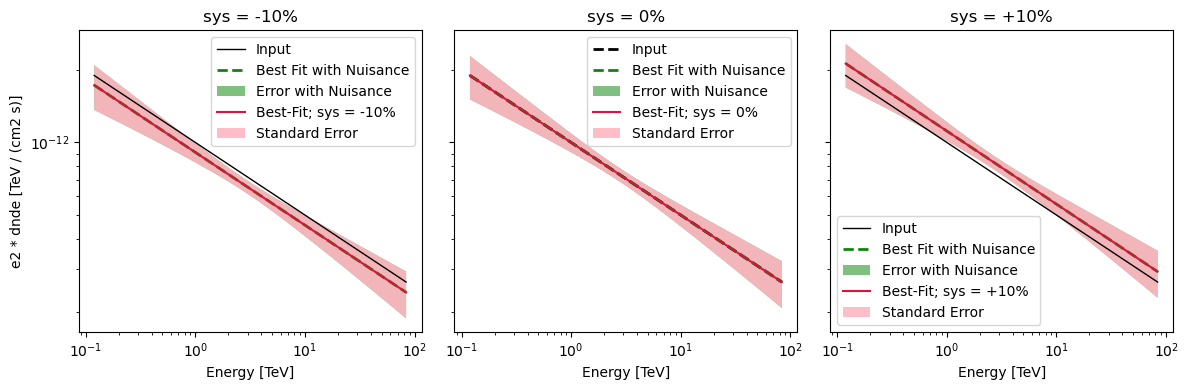

In [30]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )


dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### cor 
dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],color = 'green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
dataset_cor_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_st_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### pos 
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],color = 'green',
                                                               label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)                                              

dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_st_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
#fig.savefig("plots/2_spectrum_comparison.pdf")

index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude
index
amplitude


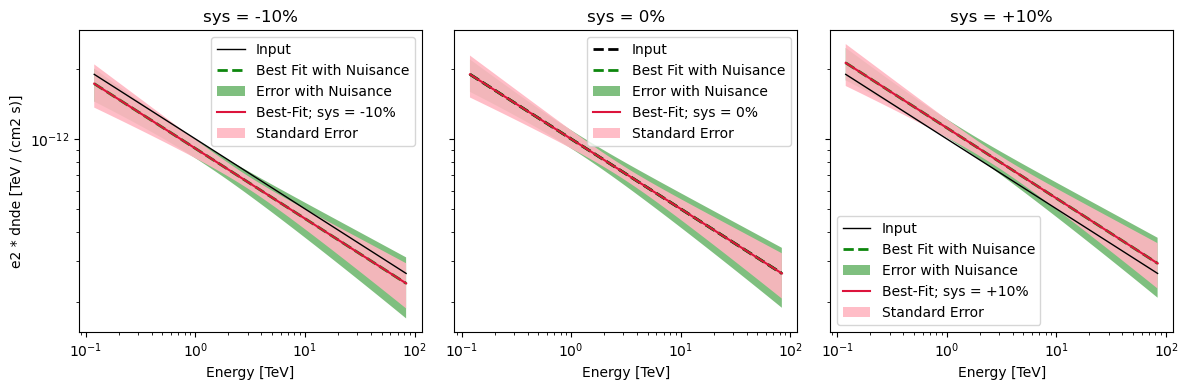

In [31]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )


dataset_neg_N.models[0].spectral_model.model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_neg_N.models[0].spectral_model.model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### cor 
dataset_cor_N.models[0].spectral_model.model.plot(energy_bounds,  energy_power = 2, ax = axs[1],color = 'green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
dataset_cor_N.models[0].spectral_model.model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_st_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### pos 
dataset_pos_N.models[0].spectral_model.model.plot(energy_bounds,  energy_power = 2, ax = axs[2],color = 'green',
                                                               label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)                                              

dataset_pos_N.models[0].spectral_model.model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_st_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
#fig.savefig("plots/2_spectrum_comparison.pdf")

In [56]:

from gammapy.modeling.models import SpectralModel
class NuisanceNorm(SpectralModel):
    
    #eff_area = Parameter("eff_area", 0.,  is_penalised = True)

    def __init__(self, model):
        self.eff_area = Parameter("eff_area", value =  0.,  is_penalised = True)

        self.model = model
        self.norm =[p for p in model.parameters if p.is_norm]
    
    @property    
    def parameters(self):
        return  Parameters.from_stack([self.model.parameters, Parameters([self.eff_area])])
    
    
    def default_parameters(self):
        return self.parameters
        
    # maybe self here is wrong:?    
    def evaluate(self, energy, **kwargs):
        print(kwargs)
        eff_area_ = kwargs.pop('eff_area')
        print(eff_area_)
        self.model.parameters[self.norm[0].name].value *= (1.+eff_area_)
        return self.model.evaluate(energy, **kwargs) 

In [57]:
test = NuisanceNorm(PowerLawSpectralModel())

In [58]:
test.parameters.names

['index', 'amplitude', 'reference', 'eff_area']

In [59]:
test.default_parameters.names

[]

In [38]:
test(1*u.TeV)

KeyError: 'eff_area'